<a href="https://colab.research.google.com/github/richardtekere09/NLP/blob/main/bow_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Imports and Setup

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Setup complete!")

# Section 2: Download NLTK Resources
# Download necessary NLTK resources - only the ones we truly need
# We'll avoid using punkt tokenizer to prevent the punkt_tab error

try:
    nltk.data.find('corpora/stopwords')
    print("stopwords already downloaded")
except LookupError:
    print("Downloading stopwords...")
    nltk.download('stopwords')

try:
    nltk.data.find('corpora/wordnet')
    print("wordnet already downloaded")
except LookupError:
    print("Downloading wordnet...")
    nltk.download('wordnet')

Setup complete!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


#Load 20 Newsgroups Dataset

In [ ]:
print("\n--- Loading 20 Newsgroups Dataset ---")
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

X_train = newsgroups_train.data
y_train = newsgroups_train.target
X_test = newsgroups_test.data
y_test = newsgroups_test.target

print(f"Dataset loaded: {len(X_train)} training samples, {len(X_test)} testing samples")
print(f"Number of categories: {len(newsgroups_train.target_names)}")
print(f"Categories: {newsgroups_train.target_names}")



--- Loading 20 Newsgroups Dataset ---
Dataset loaded: 11314 training samples, 7532 testing samples
Number of categories: 20
Categories: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


#Text Preprocessing Classes

In [ ]:
print("\n--- Defining Text Preprocessing Classes ---")

class TextPreprocessor:
    """Base text preprocessor class"""

    def __init__(self, min_word_length=3):
        self.min_word_length = min_word_length
        print(f"Initialized base TextPreprocessor with min_word_length={min_word_length}")

    def preprocess(self, text):
        """Base preprocessing method to be implemented by subclasses"""
        raise NotImplementedError

    def build_vocabulary(self, texts, max_vocab_size=None):
        """Build vocabulary from a list of texts"""
        all_words = []
        for text in texts:
            processed_text = self.preprocess(text)
            all_words.extend(processed_text)

        # Count word occurrences
        word_counts = Counter(all_words)

        # Create vocabulary dictionary
        if max_vocab_size:
            most_common = word_counts.most_common(max_vocab_size)
            vocabulary = {word: idx for idx, (word, _) in enumerate(most_common)}
        else:
            vocabulary = {word: idx for idx, word in enumerate(word_counts.keys())}

        return vocabulary

    def texts_to_bow(self, texts, vocabulary):
        """Convert texts to bag-of-words vectors"""
        vocab_size = len(vocabulary)
        bow_vectors = []

        for text in texts:
            # Initialize a zero vector
            bow_vector = np.zeros(vocab_size)

            # Process the text
            processed_text = self.preprocess(text)

            # Count word occurrences in the text
            for word in processed_text:
                if word in vocabulary:
                    bow_vector[vocabulary[word]] += 1

            bow_vectors.append(bow_vector)

        return np.array(bow_vectors)


class BasicPreprocessor(TextPreprocessor):
    """Simple text preprocessor with basic cleaning"""

    def __init__(self, min_word_length=3):
        super().__init__(min_word_length)
        print(f"Initialized BasicPreprocessor with min_word_length={min_word_length}")

    def preprocess(self, text):
        """
        Basic preprocessing:
        1. Convert to lowercase
        2. Remove punctuation
        3. Remove digits
        4. Split by whitespace
        5. Filter out short words
        """
        # Convert to lowercase
        text = text.lower()

        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))

        # Remove digits
        text = re.sub(r'\d+', '', text)

        # Split by whitespace and filter short words
        words = [word for word in text.split() if len(word) >= self.min_word_length]

        return words


class NLTKPreprocessor(TextPreprocessor):
    """Text preprocessor using NLTK components"""

    def __init__(self, remove_stopwords=True, stem=False, lemmatize=False, min_word_length=3):
        super().__init__(min_word_length)
        self.remove_stopwords = remove_stopwords
        self.stem = stem
        self.lemmatize = lemmatize

        # Initialize NLTK components
        if remove_stopwords:
            self.stop_words = set(stopwords.words('english'))

        if stem:
            self.stemmer = PorterStemmer()

        if lemmatize:
            self.lemmatizer = WordNetLemmatizer()

        print(f"Initialized NLTKPreprocessor with remove_stopwords={remove_stopwords}, stem={stem}, lemmatize={lemmatize}")

    def preprocess(self, text):
        """
        NLTK-based preprocessing:
        1. Convert to lowercase
        2. Remove punctuation
        3. Tokenize using simple split (avoiding NLTK tokenizer)
        4. Remove stopwords (optional)
        5. Apply stemming (optional)
        6. Apply lemmatization (optional)
        7. Filter out short words
        """
        # Convert to lowercase
        text = text.lower()

        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))

        # Tokenize using simple split instead of NLTK's word_tokenize to avoid punkt_tab dependency
        words = text.split()

        # Remove stopwords
        if self.remove_stopwords:
            words = [word for word in words if word not in self.stop_words]

        # Apply stemming
        if self.stem:
            words = [self.stemmer.stem(word) for word in words]

        # Apply lemmatization
        if self.lemmatize:
            words = [self.lemmatizer.lemmatize(word) for word in words]

        # Filter short words
        words = [word for word in words if len(word) >= self.min_word_length]

        return words

print("Preprocessing classes defined successfully!")


--- Defining Text Preprocessing Classes ---
Preprocessing classes defined successfully!


#PyTorch Model for Text Classification

In [ ]:
print("\n--- Defining PyTorch Model Classes ---")

class BowClassifier(nn.Module):
    """Simple PyTorch classifier for bag-of-words vectors"""

    def __init__(self, input_size, hidden_size, num_classes):
        super(BowClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, num_classes)
        )
        print(f"Initialized BowClassifier with input_size={input_size}, hidden_size={hidden_size}, num_classes={num_classes}")

    def forward(self, x):
        return self.model(x)


class NewsgroupsDataset(Dataset):
    """Dataset class for 20 Newsgroups data"""

    def __init__(self, bow_vectors, labels):
        self.bow_vectors = torch.FloatTensor(bow_vectors)
        self.labels = torch.LongTensor(labels)
        print(f"Created NewsgroupsDataset with {len(labels)} samples")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.bow_vectors[idx], self.labels[idx]

print("Model classes defined successfully!")


--- Defining PyTorch Model Classes ---
Model classes defined successfully!


#Training and Evaluation Functions

In [ ]:
print("\n--- Defining Training and Evaluation Functions ---")

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5):
    """Train the model and evaluate on test data"""
    print(f"Starting training for {num_epochs} epochs")
    train_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (batch_idx + 1) % 50 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluate on test data
        test_acc = evaluate_model(model, test_loader)
        test_accuracies.append(test_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    print("Training completed!")
    return train_losses, test_accuracies


def evaluate_model(model, data_loader):
    """Evaluate model on given data loader"""
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(targets.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    return accuracy


def detailed_evaluation(model, data_loader, target_names):
    """Perform detailed evaluation and return classification report"""
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(targets.cpu().numpy())

    report = classification_report(true_labels, predictions, target_names=target_names)
    return report

print("Training and evaluation functions defined successfully!")


--- Defining Training and Evaluation Functions ---
Training and evaluation functions defined successfully!


#Experiment Runner Function

In [ ]:
print("\n--- Defining Experiment Runner Function ---")

def run_experiment(preprocessor, vocab_sizes, X_train, y_train, X_test, y_test, preprocessor_name):
    """Run experiment with different vocabulary sizes"""
    print(f"Starting experiments with {preprocessor_name}")
    results = []

    for vocab_size in vocab_sizes:
        print(f"\n=== Running experiment with {preprocessor_name} and vocabulary size {vocab_size} ===")

        # Build vocabulary from training texts
        print(f"Building vocabulary with size {vocab_size}...")
        vocabulary = preprocessor.build_vocabulary(X_train, max_vocab_size=vocab_size)
        print(f"Vocabulary size: {len(vocabulary)}")

        # Convert texts to bag-of-words vectors
        print("Converting texts to BoW vectors...")
        X_train_bow = preprocessor.texts_to_bow(X_train, vocabulary)
        X_test_bow = preprocessor.texts_to_bow(X_test, vocabulary)
        print(f"Created BoW vectors with shape: {X_train_bow.shape} (train), {X_test_bow.shape} (test)")

        # Create datasets and data loaders
        train_dataset = NewsgroupsDataset(X_train_bow, y_train)
        test_dataset = NewsgroupsDataset(X_test_bow, y_test)

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

        # Initialize the model, loss function, and optimizer
        input_size = vocab_size
        hidden_size = 256
        num_classes = len(np.unique(y_train))

        model = BowClassifier(input_size, hidden_size, num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Train the model
        print("Training the model...")
        train_losses, test_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5)

        # Detailed evaluation
        report = detailed_evaluation(model, test_loader, newsgroups_train.target_names)
        print("\nClassification Report:")
        print(report)

        # Save results
        results.append({
            'preprocessor': preprocessor_name,
            'vocab_size': vocab_size,
            'final_accuracy': test_accuracies[-1],
            'train_losses': train_losses,
            'test_accuracies': test_accuracies,
            'model': model,  # Save the model for later use
            'vocabulary': vocabulary,  # Save the vocabulary for later use
            'preprocessor_obj': preprocessor  # Save the preprocessor object for later use
        })

        print(f"Completed experiment with {preprocessor_name} and vocabulary size {vocab_size}")

    return results

print("Experiment runner function defined successfully!")



--- Defining Experiment Runner Function ---
Experiment runner function defined successfully!


#Fixed Test Prediction with Examples Function

In [ ]:
print("\n--- Defining Test Prediction with Examples Function ---")

def test_with_examples(model, preprocessor, vocabulary, examples, target_names):
    """Test the trained model with example texts"""
    print("\n=== Testing Model with Examples ===")

    for i, example in enumerate(examples):
        print(f"\nExample {i+1}: {example[:100]}...")  # Print first 100 chars

        # Preprocess the example
        bow_vector = preprocessor.texts_to_bow([example], vocabulary)

        # Convert to tensor
        input_tensor = torch.FloatTensor(bow_vector)

        # Make prediction
        with torch.no_grad():
            model.eval()
            output = model(input_tensor)

            # Get the predicted class
            _, predicted = torch.max(output, 1)
            predicted_class = predicted.item()

        # Print results
        print(f"Predicted newsgroup: {target_names[predicted_class]}")

        # Print top 3 predictions with confidence scores
        probabilities = torch.nn.functional.softmax(output, dim=1)[0]
        top_probs, top_indices = torch.topk(probabilities, 3)

        print("Top 3 predictions:")
        for j, (prob, idx) in enumerate(zip(top_probs, top_indices)):
            print(f"  {j+1}. {target_names[idx.item()]} ({prob.item()*100:.2f}%)")

print("Test prediction function defined successfully!")



--- Defining Test Prediction with Examples Function ---
Test prediction function defined successfully!


#Example Texts for Testing

In [ ]:
print("\n--- Running Experiments ---")

# Define experiments
vocab_sizes = [1000, 2500, 5000]
print(f"Will run experiments with vocabulary sizes: {vocab_sizes}")

# Dictionary to store results
all_results = []

# 1. Basic preprocessor
print("\n--- Starting Basic Preprocessor Experiments ---")
basic_preprocessor = BasicPreprocessor(min_word_length=3)
basic_results = run_experiment(basic_preprocessor, vocab_sizes, X_train, y_train, X_test, y_test, "Basic Preprocessor")
all_results.extend(basic_results)

# 2. NLTK with stopwords removal
print("\n--- Starting NLTK + Stopwords Experiments ---")
nltk_stop_preprocessor = NLTKPreprocessor(remove_stopwords=True, stem=False, lemmatize=False)
nltk_stop_results = run_experiment(nltk_stop_preprocessor, vocab_sizes, X_train, y_train, X_test, y_test, "NLTK + Stopwords")
all_results.extend(nltk_stop_results)

# 3. NLTK with stopwords removal and stemming
print("\n--- Starting NLTK + Stopwords + Stemming Experiments ---")
nltk_stem_preprocessor = NLTKPreprocessor(remove_stopwords=True, stem=True, lemmatize=False)
nltk_stem_results = run_experiment(nltk_stem_preprocessor, vocab_sizes, X_train, y_train, X_test, y_test, "NLTK + Stopwords + Stemming")
all_results.extend(nltk_stem_results)

# 4. NLTK with stopwords removal and lemmatization
print("\n--- Starting NLTK + Stopwords + Lemmatization Experiments ---")
nltk_lemma_preprocessor = NLTKPreprocessor(remove_stopwords=True, stem=False, lemmatize=True)
nltk_lemma_results = run_experiment(nltk_lemma_preprocessor, vocab_sizes, X_train, y_train, X_test, y_test, "NLTK + Stopwords + Lemmatization")
all_results.extend(nltk_lemma_results)

# Create a DataFrame for analysis
results_df = pd.DataFrame([{
    'preprocessor': result['preprocessor'],
    'vocab_size': result['vocab_size'],
    'final_accuracy': result['final_accuracy']
} for result in all_results])

print("\nSummary of Results:")
print(results_df)



--- Running Experiments ---
Will run experiments with vocabulary sizes: [1000, 2500, 5000]

--- Starting Basic Preprocessor Experiments ---
Initialized base TextPreprocessor with min_word_length=3
Initialized BasicPreprocessor with min_word_length=3
Starting experiments with Basic Preprocessor

=== Running experiment with Basic Preprocessor and vocabulary size 1000 ===
Building vocabulary with size 1000...
Vocabulary size: 1000
Converting texts to BoW vectors...
Created BoW vectors with shape: (11314, 1000) (train), (7532, 1000) (test)
Created NewsgroupsDataset with 11314 samples
Created NewsgroupsDataset with 7532 samples
Initialized BowClassifier with input_size=1000, hidden_size=256, num_classes=20
Training the model...
Starting training for 5 epochs
Epoch [1/5], Batch [50/177], Loss: 2.7239
Epoch [1/5], Batch [100/177], Loss: 2.3763
Epoch [1/5], Batch [150/177], Loss: 2.0680
Epoch [1/5], Train Loss: 2.4223, Test Accuracy: 0.4705
Epoch [2/5], Batch [50/177], Loss: 2.4630
Epoch [2/5

#Visualizing Results


--- Visualizing Results ---
Visualization saved as 'vocabulary_size_vs_accuracy.png'


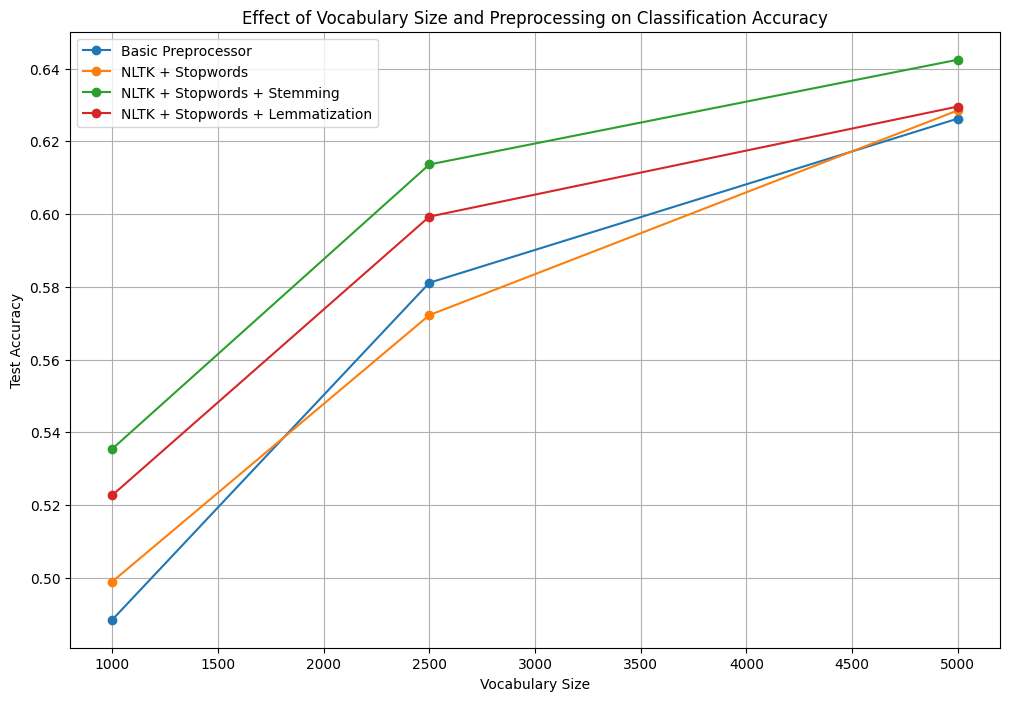

In [ ]:
print("\n--- Visualizing Results ---")

plt.figure(figsize=(12, 8))

for preprocessor_name in results_df['preprocessor'].unique():
    subset = results_df[results_df['preprocessor'] == preprocessor_name]
    plt.plot(subset['vocab_size'], subset['final_accuracy'], marker='o', label=preprocessor_name)

plt.xlabel('Vocabulary Size')
plt.ylabel('Test Accuracy')
plt.title('Effect of Vocabulary Size and Preprocessing on Classification Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('vocabulary_size_vs_accuracy.png')
print("Visualization saved as 'vocabulary_size_vs_accuracy.png'")
plt.show()


#Testing Best Model with Examples

In [ ]:
print("\n--- Testing Best Model with Examples ---")

# Find the best model based on accuracy
best_result = max(all_results, key=lambda x: x['final_accuracy'])
best_preprocessor_name = best_result['preprocessor']
best_vocab_size = best_result['vocab_size']
best_model = best_result['model']
best_vocabulary = best_result['vocabulary']
best_preprocessor = best_result['preprocessor_obj']

print(f"Using best model: {best_preprocessor_name} with vocabulary size {best_vocab_size}")
print(f"Best model accuracy: {best_result['final_accuracy']:.4f}")

# Define example texts here again in case they weren't properly defined earlier
example_texts = [
    "I have a problem with my Windows computer. It keeps crashing whenever I try to install new software. Has anyone else experienced this issue with Windows?",

    "The latest SpaceX rocket launch was incredible! The way they can land those boosters back on Earth is amazing. Does anyone know when the next mission to the ISS is scheduled?",

    "I'm looking for recommendations on a new graphics card for gaming. My current card is struggling with the latest games. I'm considering an NVIDIA RTX series, any thoughts?"
]

# Test with examples
print("\n" + "="*80)
print(f"TESTING WITH BEST MODEL: {best_preprocessor_name} (Vocabulary Size: {best_vocab_size})")
print(f"BEST MODEL ACCURACY: {best_result['final_accuracy']:.4f}")
print("="*80)

test_with_examples(best_model, best_preprocessor, best_vocabulary, example_texts, newsgroups_train.target_names)

# Display expected newsgroups for each example (simulated expected results based on content)
print("\n" + "="*80)
print("EXPECTED NEWSGROUPS (Based on Content Analysis):")
print("="*80)
print("Example 1 (Windows computer problem): Likely in 'comp.os.ms-windows.misc' or similar computer group")
print("Example 2 (SpaceX rocket launch): Likely in 'sci.space'")
print("Example 3 (Graphics card for gaming): Likely in 'comp.graphics' or similar hardware group")
print("="*80)

print("\n--- All experiments completed successfully! ---")


--- Testing Best Model with Examples ---
Using best model: NLTK + Stopwords + Stemming with vocabulary size 5000
Best model accuracy: 0.6425

TESTING WITH BEST MODEL: NLTK + Stopwords + Stemming (Vocabulary Size: 5000)
BEST MODEL ACCURACY: 0.6425

=== Testing Model with Examples ===

Example 1: I have a problem with my Windows computer. It keeps crashing whenever I try to install new software....
Predicted newsgroup: comp.os.ms-windows.misc
Top 3 predictions:
  1. comp.os.ms-windows.misc (95.91%)
  2. comp.windows.x (1.18%)
  3. comp.graphics (1.15%)

Example 2: The latest SpaceX rocket launch was incredible! The way they can land those boosters back on Earth i...
Predicted newsgroup: sci.space
Top 3 predictions:
  1. sci.space (98.48%)
  2. rec.motorcycles (0.43%)
  3. rec.autos (0.21%)

Example 3: I'm looking for recommendations on a new graphics card for gaming. My current card is struggling wit...
Predicted newsgroup: misc.forsale
Top 3 predictions:
  1. misc.forsale (46.67%)
  2.

#lab 2

Setup complete!

--- Loading 20 Newsgroups Dataset ---
Available classes: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
Selected classes: ['alt.atheism', 'comp.sys.ibm.pc.hardware']

=== Running experiment with max_length=250, kernel_size=5 ===
Training samples: 1070, Test samples: 711
Selected classes: ['alt.atheism', 'comp.sys.ibm.pc.hardware']
Initialized CharacterEncoder with vocabulary size 101
Max sequence length: 250 characters
Encoding texts...
Encoded text shapes: Train (1070, 250), Test (711, 250)
Created CharNewsDataset with 1070 samples
Created CharNewsDataset with 711 samples
Using batch size: 32
Initialized CharCNN with kernel_siz

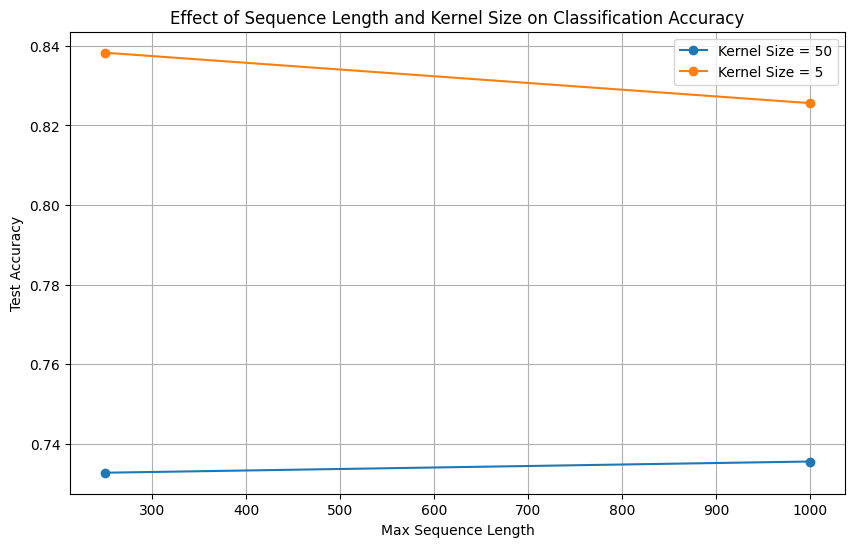

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import time
import string

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Setup complete!")

# Character-level text encoding
class CharacterEncoder:
    """
    Custom character-level text encoder
    """
    def __init__(self, max_length=500):
        # Define character set (printable ASCII characters)
        self.char_set = string.printable
        self.char_to_idx = {char: idx + 1 for idx, char in enumerate(self.char_set)}
        # Add special tokens
        self.char_to_idx['<PAD>'] = 0  # Padding token

        self.vocab_size = len(self.char_to_idx)
        self.max_length = max_length

        print(f"Initialized CharacterEncoder with vocabulary size {self.vocab_size}")
        print(f"Max sequence length: {max_length} characters")

    def encode(self, text):
        """Convert text to character-level indices"""
        # Truncate or pad the text to max_length
        if len(text) > self.max_length:
            text = text[:self.max_length]
        else:
            text = text.ljust(self.max_length, ' ')  # Pad with spaces

        # Convert characters to indices
        char_indices = [self.char_to_idx.get(char, 0) for char in text]
        return np.array(char_indices)

    def encode_texts(self, texts):
        """Encode a list of texts"""
        return np.array([self.encode(text) for text in texts])

# PyTorch Dataset for character-level text
class CharNewsDataset(Dataset):
    """Dataset class for character-level encoded text"""

    def __init__(self, encoded_texts, labels):
        self.encoded_texts = torch.LongTensor(encoded_texts)
        self.labels = torch.LongTensor(labels)
        print(f"Created CharNewsDataset with {len(labels)} samples")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.encoded_texts[idx], self.labels[idx]

# Character-level CNN model
class CharCNN(nn.Module):
    """1D Convolutional Neural Network for character-level text classification"""

    def __init__(self, vocab_size, embed_dim, kernel_size, num_classes):
        super(CharCNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # 1D Convolutional layer with padding
        self.conv1 = nn.Conv1d(embed_dim, 128, kernel_size=kernel_size, padding=kernel_size//2)
        self.conv2 = nn.Conv1d(128, 128, kernel_size=5, padding=2)

        # Pooling and activation
        self.pool = nn.MaxPool1d(3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        # FC layers will be initialized in forward pass
        self.fc1 = None
        self.fc2 = nn.Linear(128, num_classes)

        print(f"Initialized CharCNN with kernel_size={kernel_size}")

    def forward(self, x):
        # x shape: (batch_size, max_length)
        batch_size = x.size(0)

        x = self.embedding(x)  # (batch_size, max_length, embed_dim)
        x = x.permute(0, 2, 1)  # (batch_size, embed_dim, max_length)

        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # Global max pooling
        x = torch.max(x, dim=2)[0]  # (batch_size, num_filters)

        x = self.dropout(x)
        x = self.fc2(x)

        return x

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=3):
    """Train the model and evaluate on test data"""
    print(f"Starting training for {num_epochs} epochs")
    train_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        epoch_start_time = time.time()

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluate on test data
        test_acc = evaluate_model(model, test_loader)
        test_accuracies.append(test_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Accuracy: {test_acc:.4f}, Time: {epoch_time:.2f}s')

    print("Training completed!")
    return train_losses, test_accuracies

def evaluate_model(model, data_loader):
    """Evaluate model on given data loader"""
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(targets.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    return accuracy

def detailed_evaluation(model, data_loader, target_names):
    """Perform detailed evaluation and return classification report"""
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(targets.cpu().numpy())

    report = classification_report(true_labels, predictions, target_names=target_names)
    return report

def run_experiment(max_length, kernel_size, class_indices):
    """
    Run experiment with specific character sequence length and kernel size
    for the selected classes
    """
    print(f"\n=== Running experiment with max_length={max_length}, kernel_size={kernel_size} ===")

    # Select only the specified classes
    train_data = fetch_20newsgroups(subset='train', categories=[class_names[i] for i in class_indices],
                                    remove=('headers', 'footers', 'quotes'))
    test_data = fetch_20newsgroups(subset='test', categories=[class_names[i] for i in class_indices],
                                   remove=('headers', 'footers', 'quotes'))

    X_train = train_data.data
    y_train = np.array([0 if label == 0 else 1 for label in train_data.target])
    X_test = test_data.data
    y_test = np.array([0 if label == 0 else 1 for label in test_data.target])

    class_names_local = [class_names[i] for i in class_indices]

    print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
    print(f"Selected classes: {class_names_local}")

    # Character encoding
    char_encoder = CharacterEncoder(max_length=max_length)

    # Encode texts
    print("Encoding texts...")
    X_train_enc = char_encoder.encode_texts(X_train)
    X_test_enc = char_encoder.encode_texts(X_test)
    print(f"Encoded text shapes: Train {X_train_enc.shape}, Test {X_test_enc.shape}")

    # Create datasets and data loaders
    train_dataset = CharNewsDataset(X_train_enc, y_train)
    test_dataset = CharNewsDataset(X_test_enc, y_test)

    # Use smaller batch sizes for longer sequences to avoid memory issues
    batch_size = 32 if max_length <= 250 else 16
    print(f"Using batch size: {batch_size}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model, loss function, and optimizer
    vocab_size = char_encoder.vocab_size
    embed_dim = 32  # Reduced from 64 to save memory
    num_classes = len(class_indices)

    model = CharCNN(vocab_size, embed_dim, kernel_size, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model (use fewer epochs for longer sequences)
    print("Training the model...")
    epochs = 2 if max_length >= 500 else 3
    train_losses, test_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=epochs)

    # Detailed evaluation
    report = detailed_evaluation(model, test_loader, class_names_local)
    print("\nClassification Report:")
    print(report)

    # Return results
    return {
        'max_length': max_length,
        'kernel_size': kernel_size,
        'final_accuracy': test_accuracies[-1],
        'train_losses': train_losses,
        'test_accuracies': test_accuracies,
        'model': model,
        'char_encoder': char_encoder,
        'class_names': class_names_local
    }

def test_with_examples(model, char_encoder, examples, class_names):
    """Test the trained model with example texts"""
    print("\n=== Testing Model with Examples ===")

    for i, example in enumerate(examples):
        print(f"\nExample {i+1}: {example[:100]}...")  # Print first 100 chars

        # Encode the example
        encoded_example = char_encoder.encode_texts([example])

        # Convert to tensor
        input_tensor = torch.LongTensor(encoded_example)

        # Make prediction
        with torch.no_grad():
            model.eval()
            output = model(input_tensor)

            # Get the predicted class
            _, predicted = torch.max(output, 1)
            predicted_class = predicted.item()

        # Print results
        print(f"Predicted class: {class_names[predicted_class]}")

        # Print probabilities (confidence scores)
        probabilities = torch.nn.functional.softmax(output, dim=1)[0]

        for j, (prob, name) in enumerate(zip(probabilities, class_names)):
            print(f"  {name}: {prob.item()*100:.2f}%")

# Main execution
print("\n--- Loading 20 Newsgroups Dataset ---")
newsgroups = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
class_names = newsgroups.target_names
print(f"Available classes: {class_names}")

# Select two classes for the experiment (atheism and comp.graphics)
selected_class_indices = [0, 3]  # 0: 'alt.atheism', 3: 'comp.graphics'
print(f"Selected classes: {[class_names[i] for i in selected_class_indices]}")

# Define configurations to test
# For a full experiment, use all configurations below
configs = [
    {'max_length': 250, 'kernel_size': 5},
    {'max_length': 250, 'kernel_size': 50},
    {'max_length': 1000, 'kernel_size': 5},
    {'max_length': 1000, 'kernel_size': 50}
]


# Store results
all_results = []

# Run experiments
for config in configs:
    result = run_experiment(
        max_length=config['max_length'],
        kernel_size=config['kernel_size'],
        class_indices=selected_class_indices
    )
    all_results.append(result)

# Create a DataFrame for analysis
results_df = pd.DataFrame([{
    'max_length': result['max_length'],
    'kernel_size': result['kernel_size'],
    'final_accuracy': result['final_accuracy']
} for result in all_results])

print("\nSummary of Results:")
print(results_df)

# Visualize results
plt.figure(figsize=(10, 6))

# Group by kernel size
for kernel_size in set(results_df['kernel_size']):
    subset = results_df[results_df['kernel_size'] == kernel_size]
    plt.plot(subset['max_length'], subset['final_accuracy'], marker='o',
             label=f'Kernel Size = {kernel_size}')

plt.xlabel('Max Sequence Length')
plt.ylabel('Test Accuracy')
plt.title('Effect of Sequence Length and Kernel Size on Classification Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('char_cnn_accuracy.png')
print("Visualization saved as 'char_cnn_accuracy.png'")

# Find the best model based on accuracy
best_result = max(all_results, key=lambda x: x['final_accuracy'])
best_max_length = best_result['max_length']
best_kernel_size = best_result['kernel_size']
best_model = best_result['model']
best_encoder = best_result['char_encoder']
best_class_names = best_result['class_names']

print(f"\nBest model configuration: max_length={best_max_length}, kernel_size={best_kernel_size}")
print(f"Best model accuracy: {best_result['final_accuracy']:.4f}")

# Define example texts for testing
example_texts = [
    "I don't believe in god or any divine being. I think all religion is just a way to control people.",

    "Let's discuss OpenGL and 3D rendering techniques. I just upgraded my graphics card and it renders polygons amazingly fast.",

    "The concept of atheism is fundamentally about the rejection of belief in deities. Scientific reasoning doesn't find evidence for supernatural claims.",

    "I'm having trouble with my graphics driver after upgrading. The 3D models aren't displaying correctly and textures look weird.",

    "Is there any scientific evidence for the existence of god? I've been researching this topic and can't find anything convincing."
]

# Test with examples
print("\n" + "="*80)
print(f"TESTING WITH BEST MODEL: max_length={best_max_length}, kernel_size={best_kernel_size}")
print(f"BEST MODEL ACCURACY: {best_result['final_accuracy']:.4f}")
print("="*80)

test_with_examples(best_model, best_encoder, example_texts, best_class_names)

# Display expected class for each example
print("\n" + "="*80)
print("EXPECTED CLASSES (Based on Content Analysis):")
print("="*80)
print("Example 1 (Atheism statement): alt.atheism")
print("Example 2 (Graphics discussion): comp.graphics")
print("Example 3 (Atheism discussion): alt.atheism")
print("Example 4 (Graphics driver issue): comp.graphics")
print("Example 5 (Questioning god's existence): alt.atheism")
print("="*80)

print("\n--- Experiment completed successfully! ---")

### Lab 3
 Word-Level Text Processing with Embedding

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from collections import Counter

# 1. Build Vocabulary and Encode Text
def build_vocab(texts, vocab_size):
    counter = Counter()
    for text in texts:
        tokens = re.findall(r'\b\w+\b', text.lower())
        counter.update(tokens)
    most_common = counter.most_common(vocab_size - 2)
    word2idx = {word: idx + 2 for idx, (word, _) in enumerate(most_common)}
    word2idx['<PAD>'] = 0
    word2idx['<UNK>'] = 1
    return word2idx

def encode_text(text, word2idx, max_len):
    tokens = re.findall(r'\b\w+\b', text.lower())
    indices = [word2idx.get(token, 1) for token in tokens]  # 1 for <UNK>
    indices = indices[:max_len]
    return torch.tensor(indices, dtype=torch.long)

# 2. Dataset Class
class WordDataset(Dataset):
    def __init__(self, texts, labels, word2idx, max_len):
        self.texts = [encode_text(text, word2idx, max_len) for text in texts]
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

def collate_batch(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)
    return texts_padded, torch.tensor(labels)

# 3. Embedding Model
class EmbeddingClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.fc = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        embedded = self.embedding(x)  # (batch, seq_len, embed_dim)
        pooled = embedded.mean(dim=1)  # average pooling
        return self.fc(pooled)

# 4. Training Function
def run_embedding_experiment(X_train, y_train, X_test, y_test, vocab_size, embed_dim, max_len):
    word2idx = build_vocab(X_train, vocab_size)
    train_dataset = WordDataset(X_train, y_train, word2idx, max_len)
    test_dataset = WordDataset(X_test, y_test, word2idx, max_len)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_batch)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_batch)

    model = EmbeddingClassifier(len(word2idx), embed_dim, len(set(y_train)))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, test_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5)
    report = detailed_evaluation(model, test_loader, newsgroups_train.target_names)
    print(report)
    return model, word2idx, train_losses, test_accuracies

# Example Run for Different Parameters
embedding_results = []
for vocab_size in [2500, 5000, 10000]:
    for embed_dim in [50, 150, 300]:
        for max_len in [50, 100, 250]:
            print(f"\nRunning with vocab_size={vocab_size}, embed_dim={embed_dim}, max_len={max_len}")
            model, word2idx, losses, accuracies = run_embedding_experiment(X_train, y_train, X_test, y_test, vocab_size, embed_dim, max_len)
            embedding_results.append({
                'vocab_size': vocab_size,
                'embed_dim': embed_dim,
                'max_len': max_len,
                'accuracy': accuracies[-1]
            })



Running with vocab_size=2500, embed_dim=50, max_len=50
Starting training for 5 epochs
Epoch [1/5], Batch [10/177], Loss: 3.0059
Epoch [1/5], Batch [20/177], Loss: 2.9872
Epoch [1/5], Batch [30/177], Loss: 3.0077
Epoch [1/5], Batch [40/177], Loss: 2.9710
Epoch [1/5], Batch [50/177], Loss: 2.9677
Epoch [1/5], Batch [60/177], Loss: 2.9625
Epoch [1/5], Batch [70/177], Loss: 2.9622
Epoch [1/5], Batch [80/177], Loss: 2.9425
Epoch [1/5], Batch [90/177], Loss: 2.9143
Epoch [1/5], Batch [100/177], Loss: 2.8935
Epoch [1/5], Batch [110/177], Loss: 2.9239
Epoch [1/5], Batch [120/177], Loss: 2.9011
Epoch [1/5], Batch [130/177], Loss: 2.8813
Epoch [1/5], Batch [140/177], Loss: 2.9465
Epoch [1/5], Batch [150/177], Loss: 2.9148
Epoch [1/5], Batch [160/177], Loss: 2.8136
Epoch [1/5], Batch [170/177], Loss: 2.8175
Epoch [1/5], Train Loss: 2.9319, Test Accuracy: 0.1329, Time: 0.49s
Epoch [2/5], Batch [10/177], Loss: 2.8811
Epoch [2/5], Batch [20/177], Loss: 2.8259
Epoch [2/5], Batch [30/177], Loss: 2.74

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Starting training for 5 epochs
Epoch [1/5], Batch [10/177], Loss: 2.9904
Epoch [1/5], Batch [20/177], Loss: 2.9722
Epoch [1/5], Batch [30/177], Loss: 2.9895
Epoch [1/5], Batch [40/177], Loss: 2.9849
Epoch [1/5], Batch [50/177], Loss: 2.9644
Epoch [1/5], Batch [60/177], Loss: 2.9371
Epoch [1/5], Batch [70/177], Loss: 2.9987
Epoch [1/5], Batch [80/177], Loss: 2.9102
Epoch [1/5], Batch [90/177], Loss: 2.9899
Epoch [1/5], Batch [100/177], Loss: 2.9302
Epoch [1/5], Batch [110/177], Loss: 2.9410
Epoch [1/5], Batch [120/177], Loss: 2.9059
Epoch [1/5], Batch [130/177], Loss: 2.9837
Epoch [1/5], Batch [140/177], Loss: 2.9142
Epoch [1/5], Batch [150/177], Loss: 2.8914
Epoch [1/5], Batch [160/177], Loss: 2.9442
Epoch [1/5], Batch [170/177], Loss: 2.9013
Epoch [1/5], Train Loss: 2.9519, Test Accuracy: 0.1264, Time: 0.67s
Epoch [2/5], Batch [10/177], Loss: 2.8822
Epoch [2/5], Batch [20/177], Loss: 2.8914
Epoch [2/5], Batch [30/177], Loss: 2.8828
Epoch [2/5], Batch [40/177], Loss: 2.8485
Epoch [2/5]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Starting training for 5 epochs
Epoch [1/5], Batch [10/177], Loss: 2.9838
Epoch [1/5], Batch [20/177], Loss: 2.9692
Epoch [1/5], Batch [30/177], Loss: 2.9698
Epoch [1/5], Batch [40/177], Loss: 2.9601
Epoch [1/5], Batch [50/177], Loss: 2.9992
Epoch [1/5], Batch [60/177], Loss: 2.9283
Epoch [1/5], Batch [70/177], Loss: 2.9633
Epoch [1/5], Batch [80/177], Loss: 2.9118
Epoch [1/5], Batch [90/177], Loss: 2.8589
Epoch [1/5], Batch [100/177], Loss: 2.8575
Epoch [1/5], Batch [110/177], Loss: 2.8861
Epoch [1/5], Batch [120/177], Loss: 2.8509
Epoch [1/5], Batch [130/177], Loss: 2.8034
Epoch [1/5], Batch [140/177], Loss: 2.8804
Epoch [1/5], Batch [150/177], Loss: 2.8521
Epoch [1/5], Batch [160/177], Loss: 2.7205
Epoch [1/5], Batch [170/177], Loss: 2.7357
Epoch [1/5], Train Loss: 2.8926, Test Accuracy: 0.1576, Time: 0.71s
Epoch [2/5], Batch [10/177], Loss: 2.7395
Epoch [2/5], Batch [20/177], Loss: 2.6613
Epoch [2/5], Batch [30/177], Loss: 2.7194
Epoch [2/5], Batch [40/177], Loss: 2.6544
Epoch [2/5]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                          precision    recall  f1-score   support

             alt.atheism       0.22      0.15      0.18       319
           comp.graphics       0.22      0.34      0.27       389
 comp.os.ms-windows.misc       0.47      0.37      0.42       394
comp.sys.ibm.pc.hardware       0.39      0.42      0.40       392
   comp.sys.mac.hardware       0.32      0.29      0.30       385
          comp.windows.x       0.56      0.61      0.58       395
            misc.forsale       0.54      0.76      0.63       390
               rec.autos       0.39      0.29      0.34       396
         rec.motorcycles       0.35      0.39      0.37       398
      rec.sport.baseball       0.22      0.46      0.29       397
        rec.sport.hockey       0.63      0.56      0.59       399
               sci.crypt       0.57      0.46      0.51       396
         sci.electronics       0.41      0.13      0.20       393
                 sci.med       0.51      0.30      0.38       396
         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Starting training for 5 epochs
Epoch [1/5], Batch [10/177], Loss: 3.0047
Epoch [1/5], Batch [20/177], Loss: 3.0088
Epoch [1/5], Batch [30/177], Loss: 2.9860
Epoch [1/5], Batch [40/177], Loss: 2.9831
Epoch [1/5], Batch [50/177], Loss: 2.9852
Epoch [1/5], Batch [60/177], Loss: 2.9396
Epoch [1/5], Batch [70/177], Loss: 2.9861
Epoch [1/5], Batch [80/177], Loss: 2.9404
Epoch [1/5], Batch [90/177], Loss: 2.9628
Epoch [1/5], Batch [100/177], Loss: 2.9394
Epoch [1/5], Batch [110/177], Loss: 2.9371
Epoch [1/5], Batch [120/177], Loss: 2.9333
Epoch [1/5], Batch [130/177], Loss: 2.9032
Epoch [1/5], Batch [140/177], Loss: 2.9256
Epoch [1/5], Batch [150/177], Loss: 2.9293
Epoch [1/5], Batch [160/177], Loss: 2.8641
Epoch [1/5], Batch [170/177], Loss: 2.8280
Epoch [1/5], Train Loss: 2.9457, Test Accuracy: 0.1503, Time: 0.90s
Epoch [2/5], Batch [10/177], Loss: 2.8017
Epoch [2/5], Batch [20/177], Loss: 2.7945
Epoch [2/5], Batch [30/177], Loss: 2.8787
Epoch [2/5], Batch [40/177], Loss: 2.8560
Epoch [2/5]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Starting training for 5 epochs
Epoch [1/5], Batch [10/177], Loss: 3.0003
Epoch [1/5], Batch [20/177], Loss: 2.9753
Epoch [1/5], Batch [30/177], Loss: 2.9884
Epoch [1/5], Batch [40/177], Loss: 3.0030
Epoch [1/5], Batch [50/177], Loss: 2.9780
Epoch [1/5], Batch [60/177], Loss: 2.9742
Epoch [1/5], Batch [70/177], Loss: 2.9528
Epoch [1/5], Batch [80/177], Loss: 2.9708
Epoch [1/5], Batch [90/177], Loss: 2.9742
Epoch [1/5], Batch [100/177], Loss: 2.9427
Epoch [1/5], Batch [110/177], Loss: 2.9522
Epoch [1/5], Batch [120/177], Loss: 2.9318
Epoch [1/5], Batch [130/177], Loss: 2.9056
Epoch [1/5], Batch [140/177], Loss: 2.8792
Epoch [1/5], Batch [150/177], Loss: 2.9378
Epoch [1/5], Batch [160/177], Loss: 2.8542
Epoch [1/5], Batch [170/177], Loss: 2.7998
Epoch [1/5], Train Loss: 2.9497, Test Accuracy: 0.1163, Time: 0.76s
Epoch [2/5], Batch [10/177], Loss: 2.8491
Epoch [2/5], Batch [20/177], Loss: 2.8439
Epoch [2/5], Batch [30/177], Loss: 2.8341
Epoch [2/5], Batch [40/177], Loss: 2.8693
Epoch [2/5]

Summary of Embedding Experiments:
    vocab_size  embed_dim  max_len  accuracy
0         2500         50       50  0.297929
1         2500         50      100  0.321296
2         2500         50      250  0.287175
3         2500        150       50  0.371349
4         2500        150      100  0.394185
5         2500        150      250  0.393123
6         2500        300       50  0.419411
7         2500        300      100  0.444105
8         2500        300      250  0.431227
9         5000         50       50  0.313330
10        5000         50      100  0.363250
11        5000         50      250  0.343335
12        5000        150       50  0.411046
13        5000        150      100  0.452071
14        5000        150      250  0.427377
15        5000        300       50  0.465879
16        5000        300      100  0.492034
17        5000        300      250  0.506506
18       10000         50       50  0.321960
19       10000         50      100  0.380112
20       10000       

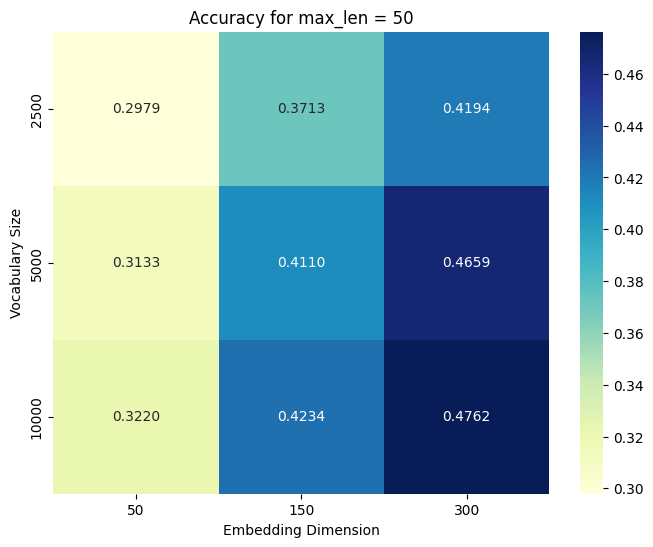

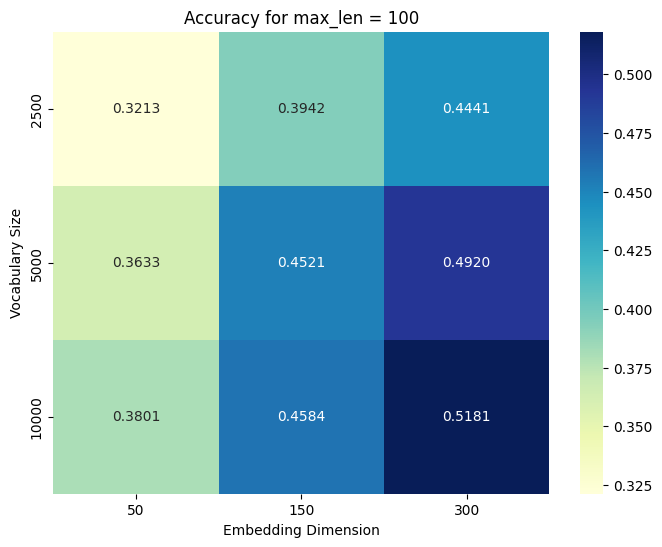

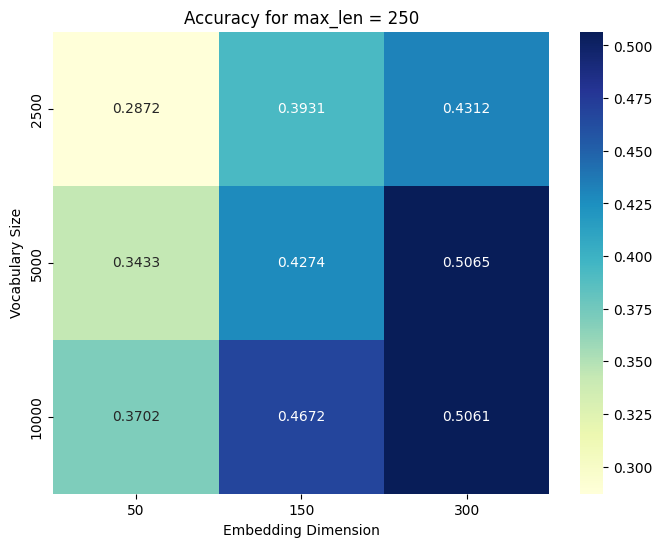

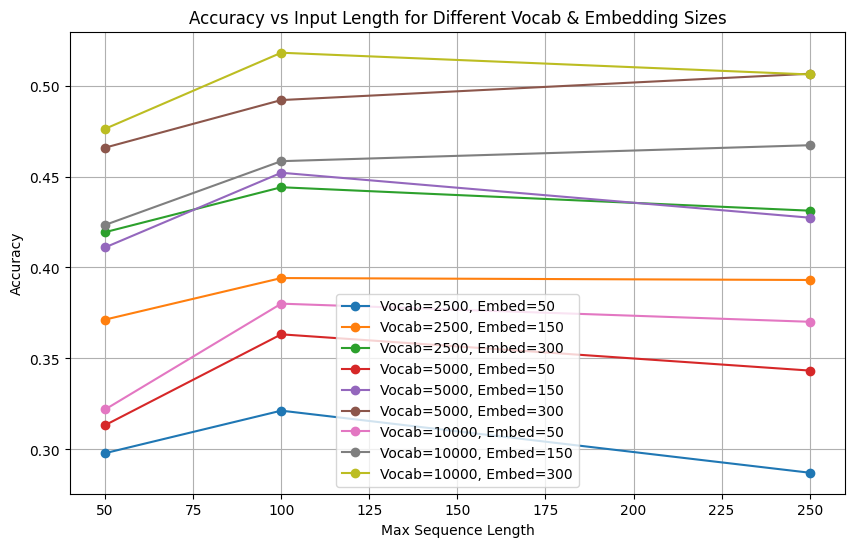

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert results to DataFrame
results_df = pd.DataFrame(embedding_results)

# Print summary table
print("Summary of Embedding Experiments:")
print(results_df)

# Example Plot: Heatmap of Accuracy vs Vocab Size and Embedding Dimension for each max_len
for max_len_val in results_df['max_len'].unique():
    subset = results_df[results_df['max_len'] == max_len_val]
    pivot_table = subset.pivot(index='vocab_size', columns='embed_dim', values='accuracy')

    plt.figure(figsize=(8,6))
    sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="YlGnBu")
    plt.title(f"Accuracy for max_len = {max_len_val}")
    plt.xlabel("Embedding Dimension")
    plt.ylabel("Vocabulary Size")
    plt.show()

# Optional: Line plot showing trend of accuracy for each vocab size and embedding dim
plt.figure(figsize=(10,6))
for vocab_size in results_df['vocab_size'].unique():
    for embed_dim in results_df['embed_dim'].unique():
        subset = results_df[(results_df['vocab_size'] == vocab_size) & (results_df['embed_dim'] == embed_dim)]
        plt.plot(subset['max_len'], subset['accuracy'], marker='o', label=f'Vocab={vocab_size}, Embed={embed_dim}')
plt.title("Accuracy vs Input Length for Different Vocab & Embedding Sizes")
plt.xlabel("Max Sequence Length")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


Confusion Matrix

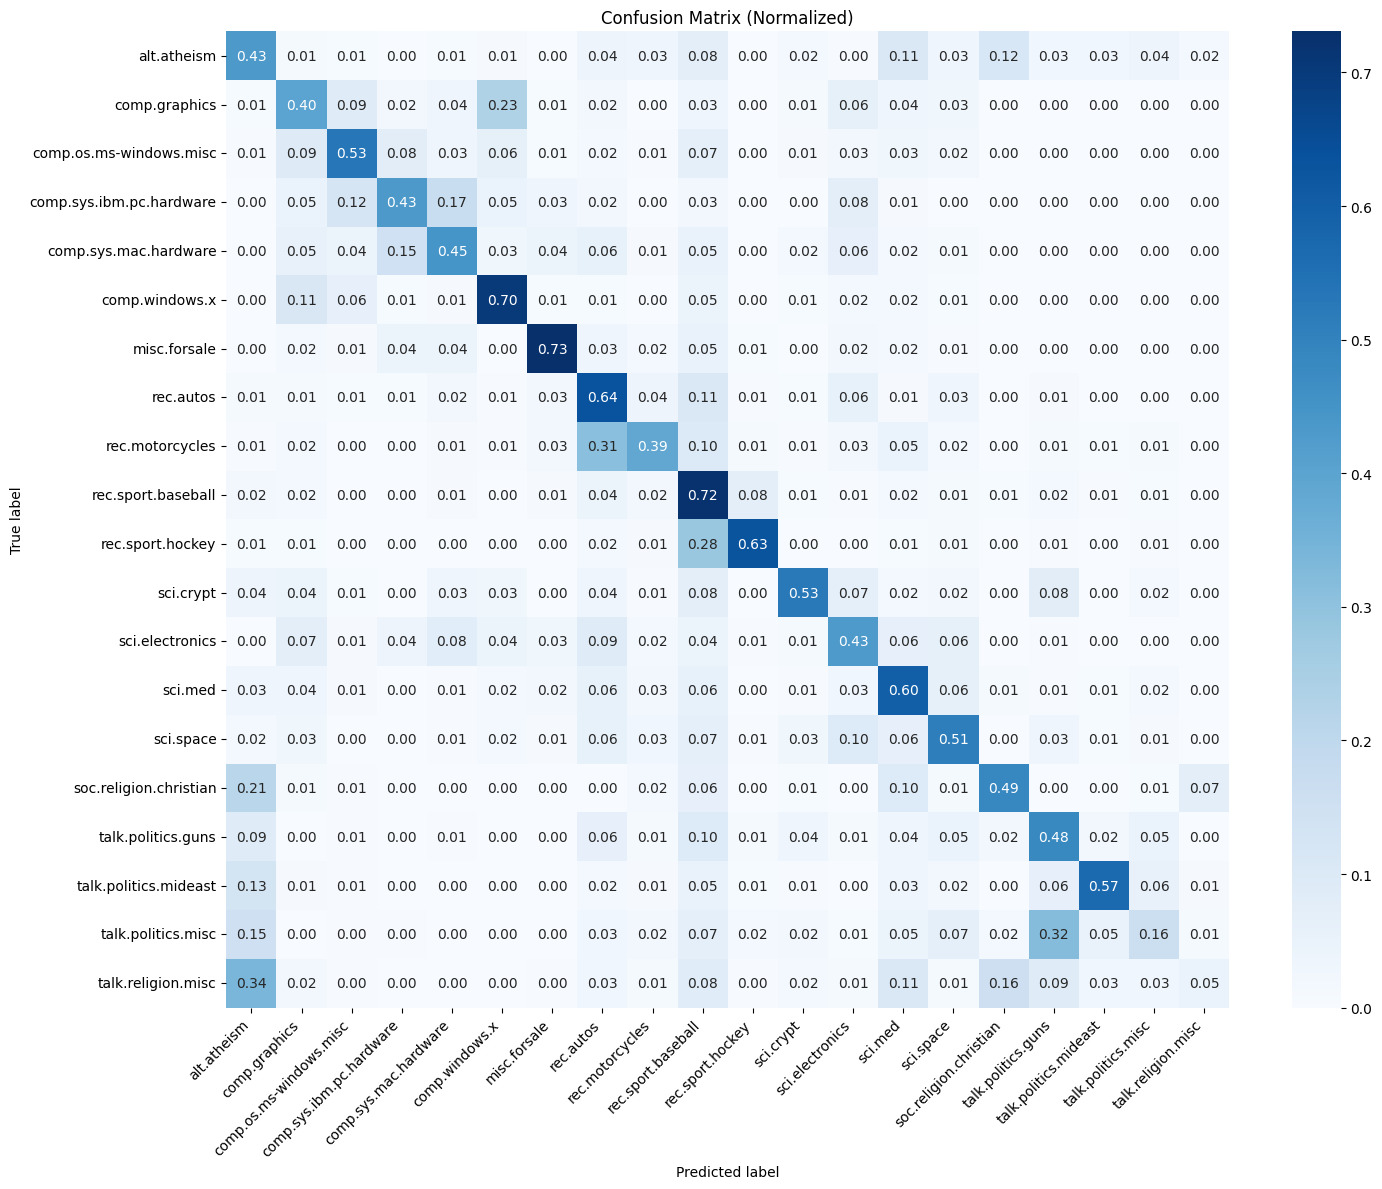

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np

# For Embedding approach:
test_dataset = WordDataset(X_test, y_test, word2idx, max_len)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_batch)

plot_confusion_matrix(model, test_loader, newsgroups_train.target_names)

def plot_confusion_matrix(model, data_loader, target_names):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            labels.extend(targets.cpu().numpy())

    cm = confusion_matrix(labels, preds)

    # Optional: Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(15, 12))  # Bigger figure
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=target_names, yticklabels=target_names, cbar=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix (Пословной обработки текстов)')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

